# Исследование и подготовка данных

1. Загрузка данных

Загрузка данных из data/epi_r.csv...

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB

Описательная статистика для рейтинга:
count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

Распределение рейтинга:


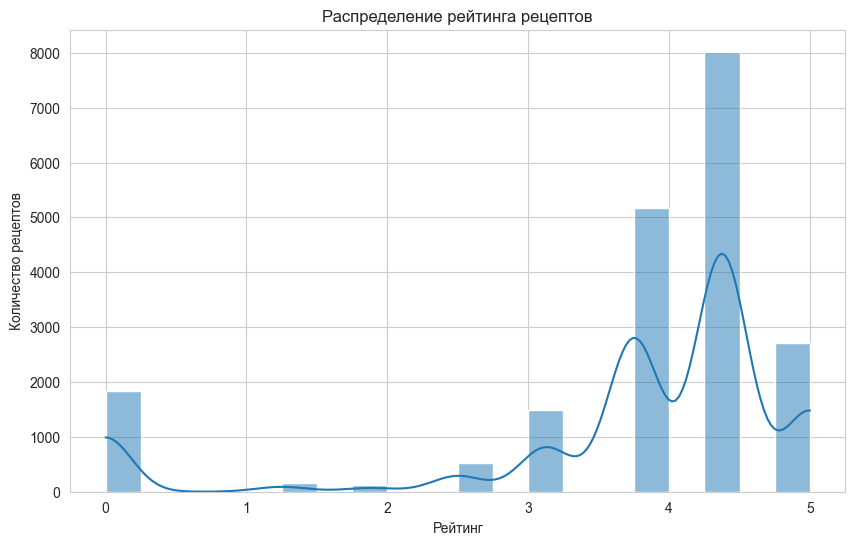

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения Pandas и Seaborn
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")

DATA_DIR = 'data'
DATA_PATH = f'{DATA_DIR}/epi_r.csv'

# Загрузка и первичный анализ данных
print(f"Загрузка данных из {DATA_PATH}...")
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    print(f"Ошибка: Файл {DATA_PATH} не найден. Убедитесь, что он находится в той же директории, что и исследование.")
    raise

print("\nИнформация о датасете:")
df.info()

print("\nОписательная статистика для рейтинга:")
print(df['rating'].describe())

print("\nРаспределение рейтинга:")
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Распределение рейтинга рецептов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество рецептов')
plt.show()

2. Обработка данных

In [9]:
print("Очистка данных от недопустимых значений в рейтинге...")
df = df.dropna(subset=['rating'])
df = df[(df['rating'] >= 0) & (df['rating'] <= 5)]

print("\nИнформация о датасете:")
df.info()


# Проверка является ли колонка названием ингредиента
import os
import json
import time
import requests

USDA_API_KEY = 'Bc6H4leueBkJ0pjSPSIRJCGGXBecrC62iS8QMUqJ'

CACHE_FILE = f'{DATA_DIR}/usda_api_cache.json'

os.makedirs(DATA_DIR, exist_ok=True)

# --- Загрузка кэша ---
def load_cache(cache_file):
    try:
        with open(cache_file, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return {}

# --- Сохранение кэша ---
def save_cache(cache, cache_file):
    with open(cache_file, 'w') as f:
        json.dump(cache, f, indent=4)


# Обертка для запроса к API с обработкой ошибок
def get_nutrition_from_usda(ingredient, api_key, max_retries = 3, retry_delay = 2):
    base_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    params = {
        'api_key': api_key,
        'query': ingredient,
        'pageSize': 1,
        'dataType': ["Foundation"]
    }
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(base_url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            if data['foods']:
                # Берем нутриенты из первого найденного продукта
                return data['foods'][0].get('foodNutrients', [])
            else:
                return None
        except requests.exceptions.RequestException as e:
            print(f"Ошибка при запросе к API для '{ingredient}': {e}")
            if e.response.status_code == 429:
                time.sleep(retry_delay)
                retries += 1
            elif e.response.status_code == 500:
                time.sleep(retry_delay)
                retries += 1
            else:
                return None
        except Exception as e:
            print(f"Неизвестная ошибка при запросе для '{ingredient}': {e}")
            return None
    return None

def is_ingredient(ingredient, api_key):
    nutrients = get_nutrition_from_usda(ingredient, api_key)
    if nutrients:
        return True
    else:
        return False
    
def preprocess_ingredient(ingredient):
    ingredient = ingredient.replace('/', ' ')
    return ingredient
    
def filter_ingredients(df, api_key):
    # --- Инициализация кэша ---
    api_cache = load_cache(CACHE_FILE)

    not_ingredient = []
    yes_ingredient = []
    for column in df.columns.tolist():
        if column in api_cache:
            if api_cache[column]:
                yes_ingredient.append(column)
            else:
                not_ingredient.append(column)
        else:
            result = is_ingredient(preprocess_ingredient(column), api_key)
            api_cache[column] = result
            if result:
                yes_ingredient.append(column)
            else:
                not_ingredient.append(column)
            
    save_cache(api_cache, CACHE_FILE)

    return yes_ingredient, not_ingredient

yes_ingredient, not_ingredient = filter_ingredients(df, USDA_API_KEY)

# Определение признаков (X) и цели (y)
X = df[yes_ingredient]
print(f"\nОпределение признаков (X), размерность: {X.shape}")

y = df['rating']
print(f"Определение цели (y), размерность: {y.shape}")


# Разделение данных на обучающую и тестовую выборки (для регрессии)

# Константа для воспроизводимости
RANDOM_STATE = 42

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE
)

print(f"\nРазмеры выборок:")
print(f"  Обучающая (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"  Тестовая (X_test, y_test):   {X_test.shape}, {y_test.shape}")


Очистка данных от недопустимых значений в рейтинге...

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB

Определение признаков (X), размерность: (20052, 343)
Определение цели (y), размерность: (20052,)

Размеры выборок:
  Обучающая (X_train, y_train): (15039, 343), (15039,)
  Тестовая (X_test, y_test):   (5013, 343), (5013,)


3. Прогнозирование - Регрессия (Анализ числового рейтинга)

Базавая регрессия на основе среднего значения

In [12]:
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

# Dummy регрессор (среднее значение)
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)
y_pred_dummy = dummy_reg.predict(X_test)
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
print(f"\nНаивный регрессор (среднее): RMSE = {rmse_dummy:.4f}")


Наивный регрессор (среднее): RMSE = 1.3244


Проработка инных методов с целью сравнения с базовой моделью

In [19]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# ### Модели регрессии
models_reg = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(random_state=RANDOM_STATE),
    "Lasso": Lasso(random_state=RANDOM_STATE),
    #"SVR": SVR(), # SVR может быть очень медленным на больших данных
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "Random Forest Regressor": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=RANDOM_STATE)
}

results_reg = {}

# Создаём пайплайн, который сначала делает импутацию, затем применяет модель Ridge
pipeline_ridge = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', models_reg["Ridge"])
])

param_grid_ridge_pipeline = {'model__alpha': [0.1, 1.0, 10.0, 100.0]}

# -- Ridge --
print("\nПодбор гиперпараметров для Ridge...")

grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge_pipeline, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
results_reg["Ridge"] = rmse_ridge
print(f"Ridge: Лучшие параметры: {grid_ridge.best_params_}, Тест RMSE = {rmse_ridge:.4f}")


Подбор гиперпараметров для Ridge...
Ridge: Лучшие параметры: {'model__alpha': 10.0}, Тест RMSE = 1.2773


In [20]:
# Подбор гиперпараметров и оценка RandomForest

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, None],
    'min_samples_split': [2, 10]
}

# -- Random Forest Regressor --
print("\nПодбор гиперпараметров для Random Forest Regressor...")
grid_rf_reg = GridSearchCV(models_reg["Random Forest Regressor"], param_grid_rf, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_rf_reg.fit(X_train, y_train)
best_rf_reg = grid_rf_reg.best_estimator_
y_pred_rf_reg = best_rf_reg.predict(X_test)
rmse_rf_reg = np.sqrt(mean_squared_error(y_test, y_pred_rf_reg))
results_reg["Random Forest Regressor"] = rmse_rf_reg
print(f"Random Forest Regressor: Лучшие параметры: {grid_rf_reg.best_params_}, Тест RMSE = {rmse_rf_reg:.4f}")



Подбор гиперпараметров для Random Forest Regressor...


KeyboardInterrupt: 

In [ ]:
import joblib
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder # Для кодирования категориальных классов


MODEL_PATH = os.path.join(DATA_DIR, 'best_classifier_model.joblib')
FEATURES_PATH = os.path.join(DATA_DIR, 'ingredient_features.joblib')
NUTRITION_DV_CSV_PATH = os.path.join(DATA_DIR, 'nutrition_facts_dv.csv')
RECIPE_URLS_CSV_PATH = os.path.join(DATA_DIR, 'recipe_urls.csv')


# ## Этап 3: Прогнозирование - Регрессия (Анализ числового рейтинга)

print("\n--- Этап 3: Регрессия ---")


# ### Вывод по регрессии
print(f"\nСравнение RMSE: Наивный={rmse_dummy:.4f}, Ridge={rmse_ridge:.4f}, RF={rmse_rf_reg:.4f}")
print("Регрессия может дать числовой прогноз, но для задачи нужны классы ('bad', 'so-so', 'great'). Переходим к классификации.")

# ## Этап 4: Прогнозирование - Классификация (Анализ классов рейтинга)

print("\n--- Этап 4: Классификация ---")

# ### Преобразование цели 1: Целые классы (0-5)
y_int = y.round().astype(int)

# Новое разделение данных со стратификацией по целым классам
X_train_cls, X_test_cls, y_train_int, y_test_int = train_test_split(
    X, y_int,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y_int # Важно для сохранения пропорций классов
)
print(f"\nРазделение для классификации (целые классы) выполнено.")
print(f"Распределение классов в y_train_int:\n{y_train_int.value_counts(normalize=True)}")

# ### Классификация по целым числам (0-5) - оценка по Accuracy
print("\nКлассификация по целым классам (0-5) - Метрика: Accuracy")
dummy_clf_int = DummyClassifier(strategy="most_frequent")
dummy_clf_int.fit(X_train_cls, y_train_int)
acc_dummy_int = dummy_clf_int.score(X_test_cls, y_test_int)
print(f"Наивный классификатор (most frequent): Accuracy = {acc_dummy_int:.4f}")

# Пример для Logistic Regression
log_reg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, n_jobs=-1) # Увеличим max_iter
# Подбор параметров не делаем для краткости, но в реальной задаче нужен
log_reg.fit(X_train_cls, y_train_int)
acc_log_reg_int = log_reg.score(X_test_cls, y_test_int)
print(f"Logistic Regression: Accuracy = {acc_log_reg_int:.4f}")


# ### Преобразование цели 2: Классы 'bad', 'so-so', 'great'
def rating_to_category(rating):
    rating_int = round(rating)
    if rating_int <= 1: return 'bad'
    elif rating_int <= 3: return 'so-so'
    else: return 'great'

y_cat = y.apply(rating_to_category)

# Кодирование категорий в числа (0, 1, 2) для некоторых моделей sklearn
label_encoder = LabelEncoder()
y_cat_encoded = label_encoder.fit_transform(y_cat)
class_names = label_encoder.classes_
print(f"\nКлассы: {class_names}") # ['bad', 'great', 'so-so'] - порядок важен!

# Новое разделение данных со стратификацией по категориям
X_train_cls, X_test_cls, y_train_cat, y_test_cat = train_test_split(
    X, y_cat_encoded,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y_cat_encoded # Стратификация по закодированным категориям
)
print(f"\nРазделение для классификации (категории 'bad', 'so-so', 'great') выполнено.")
print(f"Распределение классов в y_train_cat:\n{pd.Series(y_train_cat).map(dict(enumerate(class_names))).value_counts(normalize=True)}")


# ### Классификация по 3 классам - оценка по Accuracy
print("\nКлассификация по 3 классам - Метрика: Accuracy")
dummy_clf_cat = DummyClassifier(strategy="most_frequent")
dummy_clf_cat.fit(X_train_cls, y_train_cat)
acc_dummy_cat = dummy_clf_cat.score(X_test_cls, y_test_cat)
print(f"Наивный классификатор (most frequent): Accuracy = {acc_dummy_cat:.4f}")

# ### Переосмысление метрики -> F1-score (weighted)
print("\nТочность (Accuracy) не всегда лучшая метрика при дисбалансе или разной стоимости ошибок.")
print("Используем F1-score (weighted) для дальнейшей оценки.")

# ### Модели классификации (3 класса) с подбором параметров по F1-weighted
models_clf = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced', n_jobs=-1), # class_weight='balanced' для дисбаланса
    "Random Forest Classifier": RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=RANDOM_STATE) # GB не имеет class_weight напрямую
}

# Параметры для подбора (упрощенные для скорости)
param_grid_logreg = {'C': [0.1, 1.0, 10.0]}
param_grid_rf_clf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
param_grid_gb_clf = {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}

results_clf_f1 = {}
best_models_clf = {}

# -- Logistic Regression --
print("\nПодбор гиперпараметров для Logistic Regression (F1-weighted)...")
grid_logreg = GridSearchCV(models_clf["Logistic Regression"], param_grid_logreg, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_logreg.fit(X_train_cls, y_train_cat)
best_models_clf["Logistic Regression"] = grid_logreg.best_estimator_
y_pred_logreg_cat = best_models_clf["Logistic Regression"].predict(X_test_cls)
f1_logreg = f1_score(y_test_cat, y_pred_logreg_cat, average='weighted')
results_clf_f1["Logistic Regression"] = f1_logreg
print(f"Logistic Regression: Лучшие параметры: {grid_logreg.best_params_}, Тест F1-weighted = {f1_logreg:.4f}")
# print(classification_report(y_test_cat, y_pred_logreg_cat, target_names=class_names)) # Детальный отчет


# -- Random Forest Classifier --
print("\nПодбор гиперпараметров для Random Forest Classifier (F1-weighted)...")
grid_rf_clf = GridSearchCV(models_clf["Random Forest Classifier"], param_grid_rf_clf, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_rf_clf.fit(X_train_cls, y_train_cat)
best_models_clf["Random Forest Classifier"] = grid_rf_clf.best_estimator_
y_pred_rf_clf_cat = best_models_clf["Random Forest Classifier"].predict(X_test_cls)
f1_rf_clf = f1_score(y_test_cat, y_pred_rf_clf_cat, average='weighted')
results_clf_f1["Random Forest Classifier"] = f1_rf_clf
print(f"Random Forest Classifier: Лучшие параметры: {grid_rf_clf.best_params_}, Тест F1-weighted = {f1_rf_clf:.4f}")
# print(classification_report(y_test_cat, y_pred_rf_clf_cat, target_names=class_names))

# -- Gradient Boosting Classifier --
print("\nПодбор гиперпараметров для Gradient Boosting Classifier (F1-weighted)...")
grid_gb_clf = GridSearchCV(models_clf["Gradient Boosting Classifier"], param_grid_gb_clf, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_gb_clf.fit(X_train_cls, y_train_cat)
best_models_clf["Gradient Boosting Classifier"] = grid_gb_clf.best_estimator_
y_pred_gb_clf_cat = best_models_clf["Gradient Boosting Classifier"].predict(X_test_cls)
f1_gb_clf = f1_score(y_test_cat, y_pred_gb_clf_cat, average='weighted')
results_clf_f1["Gradient Boosting Classifier"] = f1_gb_clf
print(f"Gradient Boosting Classifier: Лучшие параметры: {grid_gb_clf.best_params_}, Тест F1-weighted = {f1_gb_clf:.4f}")
# print(classification_report(y_test_cat, y_pred_gb_clf_cat, target_names=class_names))


# ## Этап 5: Выбор и сохранение лучшей модели

print("\n--- Этап 5: Выбор и сохранение модели ---")

# Выбираем модель с лучшим F1-weighted на тесте
best_model_name = max(results_clf_f1, key=results_clf_f1.get)
best_model = best_models_clf[best_model_name]
best_f1_score = results_clf_f1[best_model_name]

print(f"\nЛучшая модель классификации: {best_model_name} с F1-weighted = {best_f1_score:.4f}")

# Важно: Переобучаем лучшую модель на ВСЕХ данных, использованных для обучения классификаторов ('bad', 'so-so', 'great')
# Используем X (все данные) и y_cat_encoded (все метки категорий)
print(f"Переобучение {best_model_name} на всех данных для классификации...")
final_model = best_model # Используем модель с лучшими параметрами
final_model.fit(X, y_cat_encoded) # Обучаем на полном наборе X и y_cat_encoded
print("Переобучение завершено.")

# Добавляем LabelEncoder в модель или сохраняем отдельно
# Можно создать пайплайн или сохранить LabelEncoder
final_model.classes_ = class_names # Сохраняем имена классов внутри модели для удобства

# Сохраняем обученную модель
print(f"Сохранение модели в {MODEL_PATH}...")
joblib.dump(final_model, MODEL_PATH)
print("Модель сохранена.")

# Сохраняем список признаков (названия колонок-ингредиентов)
ingredient_features = X.columns.tolist()
print(f"Сохранение списка признаков ({len(ingredient_features)} шт.) в {FEATURES_PATH}...")
joblib.dump(ingredient_features, FEATURES_PATH)
print("Список признаков сохранен.")


# ## Этап 6: Сбор данных о пищевой ценности (Nutrition Facts)

print("\n--- Этап 6: Сбор данных о пищевой ценности (USDA API) ---")

if not USDA_API_KEY:
    print("API Ключ USDA не установлен. Пропускаем этап сбора данных о питании.")
    all_nutrition_data = {} # Оставляем пустым, чтобы следующие шаги не упали
else:
    # Получаем уникальный список ингредиентов из наших признаков
    unique_ingredients = ingredient_features
    print(f"Найдено {len(unique_ingredients)} уникальных ингредиентов для запроса к API.")

    # Определяем целевые нутриенты (примерный маппинг, может требовать уточнения по ID из API)
    # Ключ - наше название, Значение - ID нутриента в FDC API (найти в документации или по ответам API)
    target_nutrient_ids = {
        'Protein': 203, # Protein
        'Total lipid (fat)': 204, # Total lipid (fat)
        'Carbohydrate, by difference': 205, # Carbohydrate, by difference
        'Energy': 208, # Energy (можно использовать для калорий, если нужно)
        'Sugars, total including NLEA': 269, # Sugars, total including NLEA
        'Fiber, total dietary': 291, # Fiber, total dietary
        'Calcium, Ca': 301, # Calcium, Ca
        'Iron, Fe': 303, # Iron, Fe
        'Magnesium, Mg': 304, # Magnesium, Mg
        'Phosphorus, P': 305, # Phosphorus, P (не было в списке, но часто важен)
        'Potassium, K': 306, # Potassium, K
        'Sodium, Na': 307, # Sodium, Na
        'Zinc, Zn': 309, # Zinc, Zn
        'Copper, Cu': 312, # Copper, Cu
        'Manganese, Mn': 315, # Manganese, Mn (не было в списке)
        'Selenium, Se': 317, # Selenium, Se
        'Vitamin C, total ascorbic acid': 401, # Vitamin C, total ascorbic acid
        'Thiamin': 404, # Thiamin (B1)
        'Riboflavin': 405, # Riboflavin (B2)
        'Niacin': 406, # Niacin (B3)
        'Vitamin B-6': 415, # Vitamin B-6
        'Folate, total': 417, # Folate, total
        'Vitamin B-12': 418, # Vitamin B-12
        'Vitamin A, RAE': 320, # Vitamin A, RAE (Retinol Activity Equivalents)
        'Vitamin E (alpha-tocopherol)': 323, # Vitamin E (alpha-tocopherol)
        'Vitamin D (D2 + D3)': 328, # Vitamin D (D2 + D3), International Units
        'Vitamin K (phylloquinone)': 430, # Vitamin K (phylloquinone)
        # Закомментированные - из исходного README, но могут не быть напрямую в FDC или иметь другие ID/названия
        # 'Chromium, Cr': - ID не стандартный, может отсутствовать
        # 'Iodine, I': - ID не стандартный, может отсутствовать
    }
    target_nutrient_ids_reverse_map = {v: k for k, v in target_nutrient_ids.items()}

    def search_fdc_id(ingredient_name, api_key):
        """Ищет FDC ID для ингредиента."""
        base_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
        params = {
            'query': ingredient_name,
            'api_key': api_key,
            'pageSize': 1, # Берем только первый результат
            'dataType': 'Branded,Foundation,SR Legacy' # Ищем в разных типах данных
        }
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status() # Проверка на HTTP ошибки
            data = response.json()
            if data['foods'] and len(data['foods']) > 0:
                return data['foods'][0]['fdcId']
            else:
                print(f"  Предупреждение: FDC ID не найден для '{ingredient_name}'")
                return None
        except requests.exceptions.RequestException as e:
            print(f"  Ошибка API при поиске '{ingredient_name}': {e}")
            return None
        except Exception as e:
            print(f"  Неожиданная ошибка при поиске '{ingredient_name}': {e}")
            return None

    def get_nutrition_details(fdc_id, api_key, target_ids_map):
        """Получает детали по нутриентам для FDC ID."""
        base_url = f"https://api.nal.usda.gov/fdc/v1/food/{fdc_id}"
        params = {'api_key': api_key}
        nutrients_found = {}
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()
            # Ищем нутриенты в ответе API
            for nutrient in data.get('foodNutrients', []):
                nutrient_id = nutrient.get('nutrient', {}).get('id')
                if nutrient_id in target_ids_map:
                    nutrient_name = target_ids_map[nutrient_id]
                    nutrients_found[nutrient_name] = {
                        'value': nutrient.get('amount', 0),
                        'unit': nutrient.get('nutrient', {}).get('unitName', '').lower()
                    }
            if not nutrients_found:
                 print(f"  Предупреждение: Целевые нутриенты не найдены для FDC ID {fdc_id}")
            return nutrients_found
        except requests.exceptions.RequestException as e:
            print(f"  Ошибка API при получении деталей для FDC ID {fdc_id}: {e}")
            return None
        except Exception as e:
            print(f"  Неожиданная ошибка при получении деталей для FDC ID {fdc_id}: {e}")
            return None

    # --- Цикл сбора данных ---
    all_nutrition_data = {}
    processed_count = 0
    total_ingredients = len(unique_ingredients)

    print("\nНачинаем сбор данных о питании (может занять много времени)...")
    for ingredient in unique_ingredients:
        processed_count += 1
        print(f"Обработка: {ingredient} ({processed_count}/{total_ingredients})")

        # Проверяем, есть ли уже данные (на случай перезапуска)
        if ingredient in all_nutrition_data:
            print("  Данные уже есть, пропускаем.")
            continue

        fdc_id = search_fdc_id(ingredient, USDA_API_KEY)
        if fdc_id:
            details = get_nutrition_details(fdc_id, USDA_API_KEY, target_nutrient_ids_reverse_map)
            if details:
                all_nutrition_data[ingredient] = details
            else:
                all_nutrition_data[ingredient] = {} # Запись, что не найдено
        else:
             all_nutrition_data[ingredient] = {} # Запись, что ID не найден

        time.sleep(1.1) # Пауза между запросами, чтобы не превысить лимит API

    print("\nСбор данных о питании завершен.")
    # Посмотрим пример для одного ингредиента
    if 'milk' in all_nutrition_data:
         print("\nПример данных для 'milk':")
         print(all_nutrition_data['milk'])


# ## Этап 7: Обработка данных о пищевой ценности (%DV)

print("\n--- Этап 7: Расчет % Дневной Нормы (%DV) ---")

# ### Определение Дневных Норм (DV)
# На основе ссылок из README (примерные значения, могут отличаться в зависимости от стандартов FDA)
# Единицы измерения должны соответствовать ожидаемым из API или быть конвертируемыми.
# Используем те же ключи, что и в target_nutrient_ids
daily_values = {
    # Макронутриенты (основаны на 2000 ккал диете)
    'Total lipid (fat)': {'amount': 78, 'unit': 'g'},
    'Carbohydrate, by difference': {'amount': 275, 'unit': 'g'},
    'Protein': {'amount': 50, 'unit': 'g'},
    'Fiber, total dietary': {'amount': 28, 'unit': 'g'},
    'Sugars, total including NLEA': {'amount': 50, 'unit': 'g'}, # Added sugars DV

    # Минералы
    'Calcium, Ca': {'amount': 1300, 'unit': 'mg'},
    'Iron, Fe': {'amount': 18, 'unit': 'mg'},
    'Magnesium, Mg': {'amount': 420, 'unit': 'mg'},
    'Phosphorus, P': {'amount': 1250, 'unit': 'mg'},
    'Potassium, K': {'amount': 4700, 'unit': 'mg'},
    'Sodium, Na': {'amount': 2300, 'unit': 'mg'}, # Обратите внимание, это ВЕРХНИЙ предел
    'Zinc, Zn': {'amount': 11, 'unit': 'mg'},
    'Copper, Cu': {'amount': 0.9, 'unit': 'mg'}, # Или 900 mcg
    'Manganese, Mn': {'amount': 2.3, 'unit': 'mg'},
    'Selenium, Se': {'amount': 55, 'unit': 'mcg'},
    # 'Chromium, Cr': {'amount': 35, 'unit': 'mcg'}, # Не всегда указывается
    # 'Iodine, I': {'amount': 150, 'unit': 'mcg'}, # Не всегда указывается

    # Витамины
    'Vitamin C, total ascorbic acid': {'amount': 90, 'unit': 'mg'},
    'Thiamin': {'amount': 1.2, 'unit': 'mg'},
    'Riboflavin': {'amount': 1.3, 'unit': 'mg'},
    'Niacin': {'amount': 16, 'unit': 'mg'}, # NE
    'Vitamin B-6': {'amount': 1.7, 'unit': 'mg'},
    'Folate, total': {'amount': 400, 'unit': 'mcg'}, # DFE
    'Vitamin B-12': {'amount': 2.4, 'unit': 'mcg'},
    'Vitamin A, RAE': {'amount': 900, 'unit': 'mcg'}, # RAE
    'Vitamin E (alpha-tocopherol)': {'amount': 15, 'unit': 'mg'}, # Alpha-tocopherol
    'Vitamin D (D2 + D3)': {'amount': 20, 'unit': 'mcg'}, # Или 800 IU (конверсия зависит от формы)
    'Vitamin K (phylloquinone)': {'amount': 120, 'unit': 'mcg'},
}

# ### Функция конвертации единиц (пример)
def convert_units(value, unit_from, unit_to):
    unit_from = unit_from.lower()
    unit_to = unit_to.lower()

    if unit_from == unit_to:
        return value

    # Граммы <-> Миллиграммы
    if unit_from == 'g' and unit_to == 'mg': return value * 1000
    if unit_from == 'mg' and unit_to == 'g': return value / 1000
    # Миллиграммы <-> Микрограммы
    if unit_from == 'mg' and unit_to == 'mcg': return value * 1000
    if unit_from == 'mcg' and unit_to == 'mg': return value / 1000
    # Граммы <-> Микрограммы
    if unit_from == 'g' and unit_to == 'mcg': return value * 1000000
    if unit_from == 'mcg' and unit_to == 'g': return value / 1000000
    # IU <-> mcg (Пример для Витамина D, конверсия может быть сложной!)
    # 1 IU = 0.025 mcg для Витамина D
    if 'vitamin d' in unit_from and unit_from == 'iu' and unit_to == 'mcg': return value * 0.025
    if 'vitamin d' in unit_to and unit_to == 'iu' and unit_from == 'mcg': return value / 0.025

    # Если конверсия не найдена
    print(f"  Предупреждение: Не удалось конвертировать {value} из '{unit_from}' в '{unit_to}'")
    return None # Или вернуть исходное значение? Лучше None

# ### Расчет %DV
nutrition_dv_data = {}

print("\nРасчет %DV для каждого ингредиента и нутриента...")
for ingredient, nutrients in all_nutrition_data.items():
    if not nutrients: # Если для ингредиента вообще не было данных
        nutrition_dv_data[ingredient] = {}
        continue

    dv_for_ingredient = {}
    for nutrient_name, data in nutrients.items():
        if nutrient_name in daily_values:
            dv_info = daily_values[nutrient_name]
            dv_amount = dv_info['amount']
            dv_unit = dv_info['unit']
            api_value = data['value']
            api_unit = data['unit']

            # Проверка и конвертация единиц
            converted_value = convert_units(api_value, api_unit, dv_unit)

            if converted_value is not None and dv_amount > 0:
                percent_dv = (converted_value / dv_amount) * 100
                # Округляем до 1 знака после запятой
                dv_for_ingredient[nutrient_name] = round(percent_dv, 1)
            #else:
                # Не считаем %DV если конвертация не удалась или DV=0

    nutrition_dv_data[ingredient] = dv_for_ingredient

# ### Создание и сохранение DataFrame
df_nutrition_dv = pd.DataFrame.from_dict(nutrition_dv_data, orient='index')
# Заполняем пропуски нулями (если нутриент не найден или %DV не посчитан)
df_nutrition_dv.fillna(0, inplace=True)

# Переименуем индекс для ясности
df_nutrition_dv.index.name = 'ingredient_name'

print(f"\nСоздан DataFrame с %DV на 100г (shape: {df_nutrition_dv.shape})")
print("Первые 5 строк:")
print(df_nutrition_dv.head())

print(f"\nСохранение данных о %DV в {NUTRITION_DV_CSV_PATH}...")
df_nutrition_dv.to_csv(NUTRITION_DV_CSV_PATH)
print("Данные сохранены.")


# ## Этап 8: Подготовка данных для поиска похожих рецептов

print("\n--- Этап 8: Подготовка данных для поиска похожих рецептов ---")

# Используем исходный DataFrame df_raw, но отфильтрованный по тем же строкам, что и df_model
df_recipes_final = df_raw.loc[df_model.index].copy()

# ### Генерация URL (если их нет в исходных данных)
# Это заглушка, так как реальные URL требуют парсинга или другого источника
# Формат URL из примера: https://www.epicurious.com/recipes/food/views/НАЗВАНИЕ-РЕЦЕПТА-ID
# Попробуем создать что-то похожее из title (очень не надежно!)
def generate_dummy_url(title):
    if pd.isna(title): return None
    slug = str(title).lower().replace(' ', '-').replace(',', '').replace('.', '').replace('&', 'and')
    # Убираем лишние символы, которые могут ломать URL
    slug = ''.join(e for e in slug if e.isalnum() or e == '-')
    return f"https://www.epicurious.com/recipes/food/views/{slug}-xxxxx" # xxxxx - плейсхолдер ID

if 'url' not in df_recipes_final.columns:
    print("Колонка 'url' отсутствует, генерируем заглушки...")
    df_recipes_final['url'] = df_recipes_final['title'].apply(generate_dummy_url)

# ### Выбор необходимых колонок
# Нужны: title, rating, url и колонки-ингредиенты из списка `ingredient_features`
final_recipe_cols = ['title', 'rating', 'url'] + ingredient_features
df_recipes_final = df_recipes_final[final_recipe_cols]

# ### Обработка пропусков в URL (если они есть или сгенерировались как None)
initial_recipe_rows = len(df_recipes_final)
df_recipes_final.dropna(subset=['url'], inplace=True)
print(f"\nУдалено {initial_recipe_rows - len(df_recipes_final)} строк с отсутствующим URL.")

# ### (Бонус) Добавление типа блюда
print("\n(Бонус) Добавление колонки 'meal_type'...")
def assign_meal_type(title):
    if pd.isna(title): return 'unknown'
    title_low = title.lower()
    # Простые правила на основе ключевых слов (можно значительно улучшить)
    if any(word in title_low for word in ['breakfast', 'omelet', 'pancake', 'muffin', 'egg', 'waffle', 'smoothie']):
        return 'breakfast'
    elif any(word in title_low for word in ['lunch', 'salad', 'soup', 'sandwich', 'wrap', 'bowl']):
        return 'lunch'
    elif any(word in title_low for word in ['dinner', 'roast', 'pasta', 'chicken', 'beef', 'fish', 'stew', 'casserole', 'main course']):
        return 'dinner'
    else:
        # Если не подходит под основные, может быть десертом, закуской и т.д.
        # Для простоты оставим 'unknown', или можно добавить другие категории
         if any(word in title_low for word in ['cake', 'cookie', 'pie', 'dessert', 'ice cream']):
             return 'dessert' # Или отнести к 'unknown' / 'other'
         else:
             return 'unknown' # Или 'snack' / 'other'

df_recipes_final['meal_type'] = df_recipes_final['title'].apply(assign_meal_type)
print("Колонка 'meal_type' добавлена. Распределение:")
print(df_recipes_final['meal_type'].value_counts())

# ### Сохранение DataFrame
print(f"\nИтоговый DataFrame для поиска рецептов (shape: {df_recipes_final.shape})")
print("Первые 5 строк:")
print(df_recipes_final.head())

print(f"\nСохранение данных о рецептах (с URL и ингредиентами) в {RECIPE_URLS_CSV_PATH}...")
df_recipes_final.to_csv(RECIPE_URLS_CSV_PATH, index=False) # index=False, т.к. индекс не нужен
print("Данные сохранены.")


# ## Этап 9: Заключение

print("\n--- Этап 9: Заключение ---")
print("Исследовательская работа в ноутбуке завершена.")
print("Созданные артефакты:")
print(f"  - Модель классификации: {MODEL_PATH}")
print(f"  - Список признаков модели: {FEATURES_PATH}")
print(f"  - Данные о пищевой ценности (%DV): {NUTRITION_DV_CSV_PATH}")
print(f"  - Данные рецептов для поиска схожих (с URL): {RECIPE_URLS_CSV_PATH}")
print("\nЭти файлы готовы для использования в модуле recipes.py и основном скрипте nutritionist.py.")